# Data Exploration and Preparation
The goal of this chapter is to prepare the dataset for subsequent machine learning modeling. We will begin by loading the data, examining its basic structure and quality, and then proceed with necessary data cleaning and feature engineering. Finally, through preliminary Exploratory Data Analysis (EDA), we will uncover early patterns in the data to inform our modeling strategy.

## Initial Data Loading and Assessment
The first step in our analysis is to load the dataset and evaluate its basic structure. We will use the pandas library to read the Clean_Dataset.csv file and utilize functions like .info(), .head(), and .describe() to understand the data's dimensions, data types, missing values, and basic statistics of numerical features.

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
try:
    df = pd.read_csv('Clean_Dataset.csv')
except FileNotFoundError:
    print("Please ensure 'Clean_Dataset.csv' is in the same directory as the notebook.")
    # In some environments, you might need to provide the full file path
    # df = pd.read_csv('/path/to/your/Clean_Dataset.csv')

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Display basic information about the dataset (data types, non-null counts, etc.)
print("\nDataset Information:")
df.info()

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics for Numerical Features:")
print(df.describe())

# Check for the total number of missing values
print(f"\nTotal number of missing values in the dataset: {df.isnull().sum().sum()}")

First 5 rows of the dataset:
   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (tota

## Data Preprocessing and Feature Engineering
To make the raw data suitable for machine learning models, we need to perform a series of transformations. This includes ordinally encoding categorical features with an inherent order (like stops) and creating new features that can more effectively capture pricing patterns (like route).

**Categorical Feature Handling**
1. Ordinal Encoding of stops Feature: The values in the stops column ('zero', 'one', 'two_or_more') have a clear sequential relationship. Therefore, we will convert them into numerical values (0, 1, 2) to preserve this information.

2. Creation of route Feature: Airline pricing strategy is key. We will combine source_city and destination_city to create a route feature, allowing the model to more directly learn the price patterns of specific routes.

In [7]:
# Create a copy of the original dataframe for modifications
df_processed = df.copy()

# Perform ordinal encoding on the 'stops' column
stops_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
df_processed['stops'] = df_processed['stops'].map(stops_mapping)

# Create the 'route' feature
df_processed['route'] = df_processed['source_city'] + '-' + df_processed['destination_city']

# Display the first few rows after processing to confirm changes
print("Dataset after processing 'stops' and creating 'route' feature:")
print(df_processed.head())

# Check if the data type of the 'stops' column has changed to a numeric type
print("\nProcessed Dataset Information:")
df_processed.info()

Dataset after processing 'stops' and creating 'route' feature:
   Unnamed: 0   airline   flight source_city departure_time  stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening      0   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning      0   
2           2   AirAsia   I5-764       Delhi  Early_Morning      0   
3           3   Vistara   UK-995       Delhi        Morning      0   
4           4   Vistara   UK-963       Delhi        Morning      0   

    arrival_time destination_city    class  duration  days_left  price  \
0          Night           Mumbai  Economy      2.17          1   5953   
1        Morning           Mumbai  Economy      2.33          1   5953   
2  Early_Morning           Mumbai  Economy      2.17          1   5956   
3      Afternoon           Mumbai  Economy      2.25          1   5955   
4        Morning           Mumbai  Economy      2.33          1   5955   

          route  
0  Delhi-Mumbai  
1  Delhi-Mumbai  
2  Delhi-Mumbai  

## Exploratory Data Analysis (EDA)
After data preparation, we conduct exploratory analysis using visualizations to intuitively understand the underlying patterns in the data.

**Distribution of the Target Variable ‘price’**
First, we analyze the distribution of our target variable, price. The distribution of raw prices is often right-skewed, meaning there are a few flights with extremely high prices. This skewness can affect the performance of some models. Therefore, we typically apply a logarithmic transformation to make the distribution more closely resemble a normal distribution, which can improve model stability and learning efficiency.

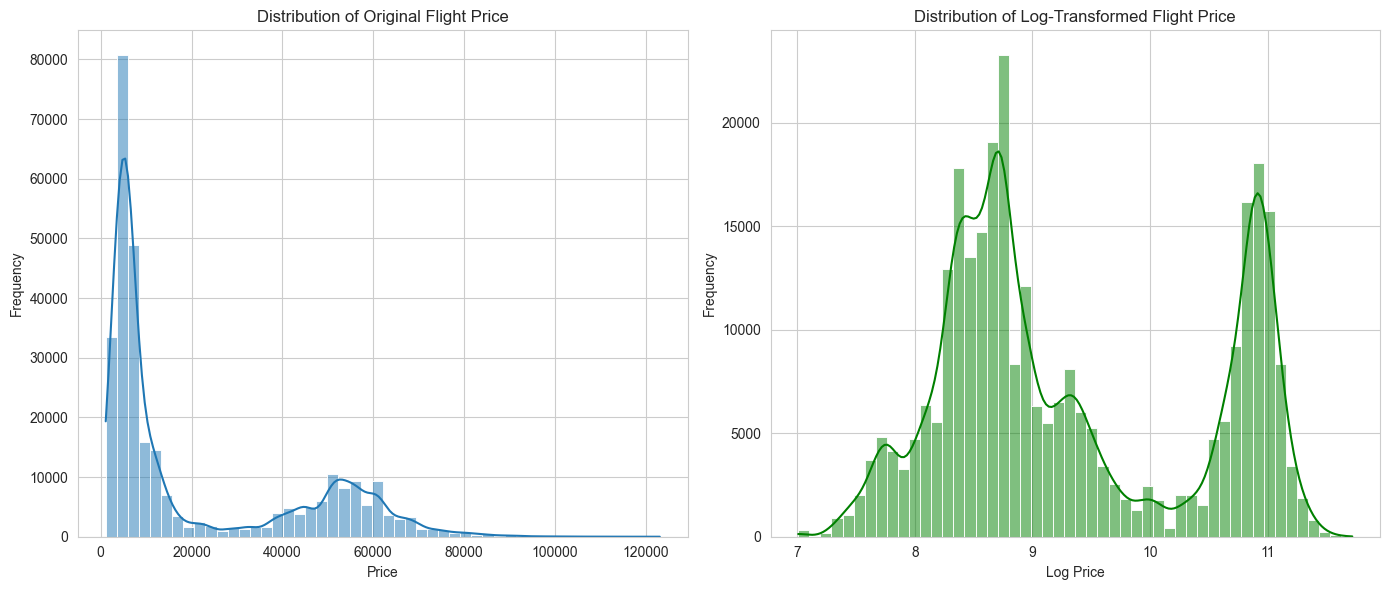

In [8]:
# Plot the distribution of flight prices
plt.figure(figsize=(14, 6))

# Distribution of original prices
plt.subplot(1, 2, 1)
sns.histplot(df_processed['price'], kde=True, bins=50)
plt.title('Distribution of Original Flight Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Distribution of log-transformed prices
# We use np.log1p for a stable transformation that handles zero values (though price is not zero here)
df_processed['log_price'] = np.log1p(df_processed['price'])
plt.subplot(1, 2, 2)
sns.histplot(df_processed['log_price'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed Flight Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Core Relationship: price vs. days_left**

We investigate the relationship between the ticket price and the booking lead time (days_left). A scatter plot can help us visually determine if the mean and variance of prices increase as the departure date approaches.

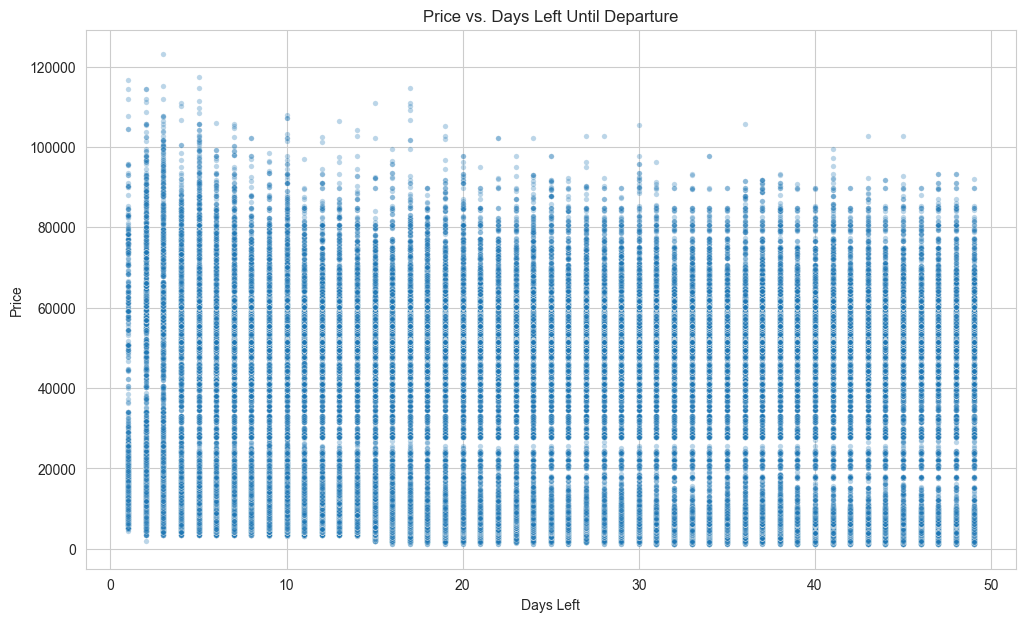

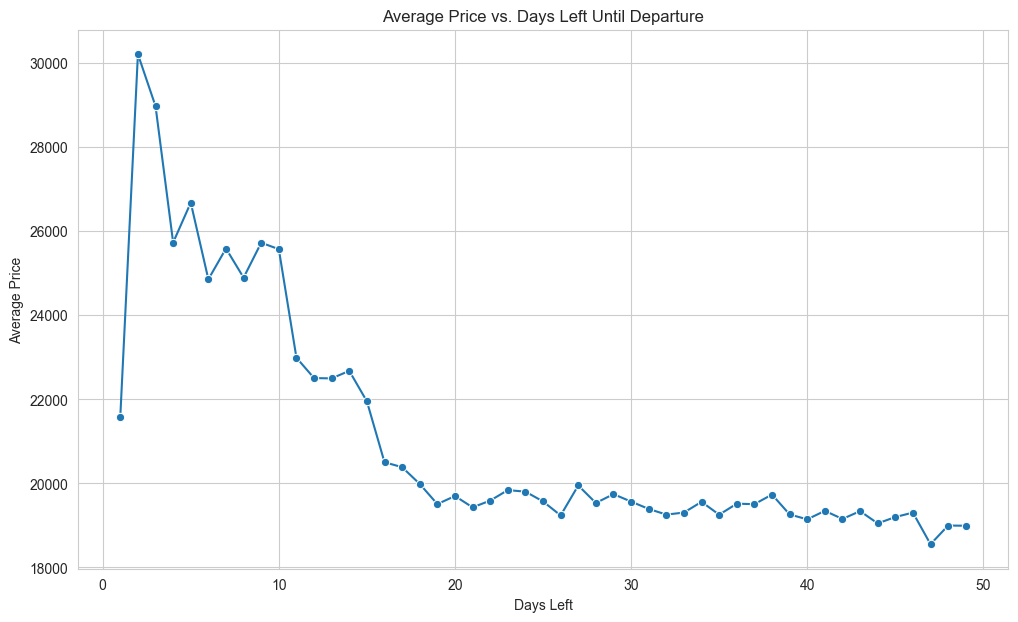

In [9]:
# Plot the relationship between price and days left until departure
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_processed, x='days_left', y='price', alpha=0.3, s=15)
plt.title('Price vs. Days Left Until Departure')
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.show()

# To better observe the trend, we can plot the mean price for each day
mean_price_by_days_left = df_processed.groupby('days_left')['price'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.lineplot(data=mean_price_by_days_left, x='days_left', y='price', marker='o')
plt.title('Average Price vs. Days Left Until Departure')
plt.xlabel('Days Left')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

**Hierarchical Pricing by Service class**

The class of service is a critical factor influencing ticket prices. Using a box plot, we can clearly compare the price distribution differences between Economy and Business classes.

C:\Users\80999\AppData\Local\Temp\ipykernel_8832\359273017.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='class', y='price', palette='viridis')


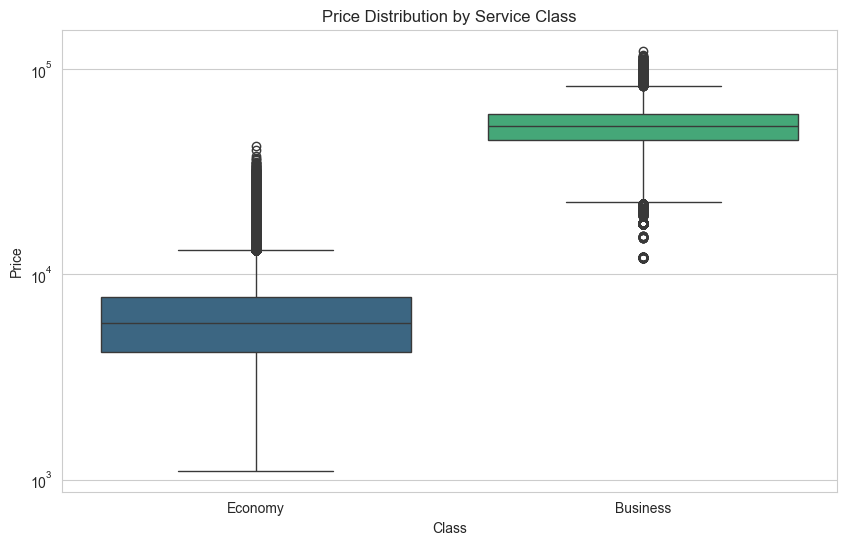

In [10]:
# Compare the price distribution across different service classes
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_processed, x='class', y='price', palette='viridis')
plt.title('Price Distribution by Service Class')
plt.xlabel('Class')
plt.ylabel('Price')
plt.yscale('log') # Use a log scale to better visualize the distributions, especially for Economy
plt.show()

# Deep Dive into Key Pricing Determinants
Following the initial data exploration and preparation, this chapter delves deeper into quantifying the specific impact of different features on flight prices. Through a series of visualizations, we will uncover how convenience, airline branding, geographical routes, and travel times collectively shape the complex pricing mechanism.

## The Trade-off: Impact of stops and duration on Price
The number of stops and the flight duration are two core metrics of a flight's convenience. It is commonly assumed that more stops and longer durations should lead to lower prices. However, our visual analysis will reveal a more interesting, non-linear relationship.


C:\Users\80999\AppData\Local\Temp\ipykernel_8832\552697388.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='stops', y='price', palette='coolwarm')


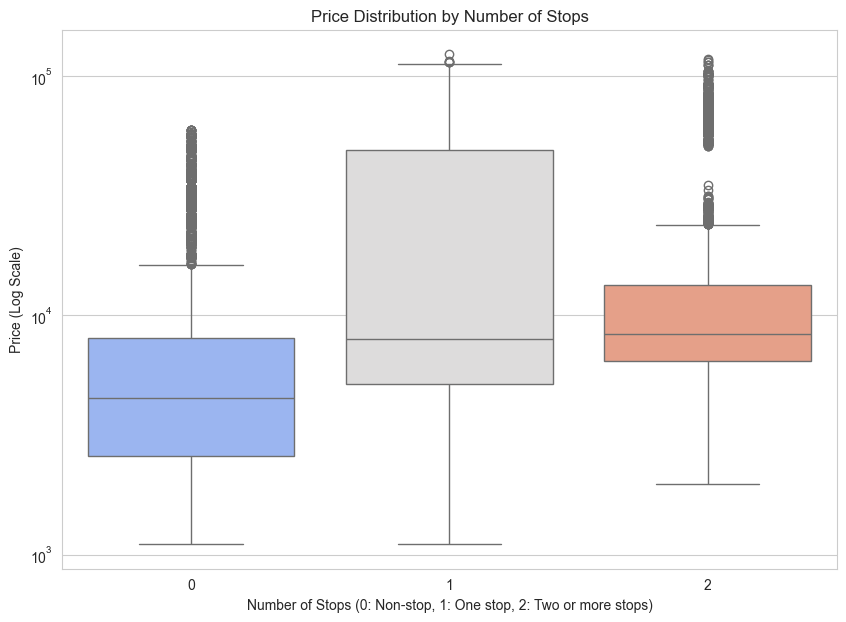

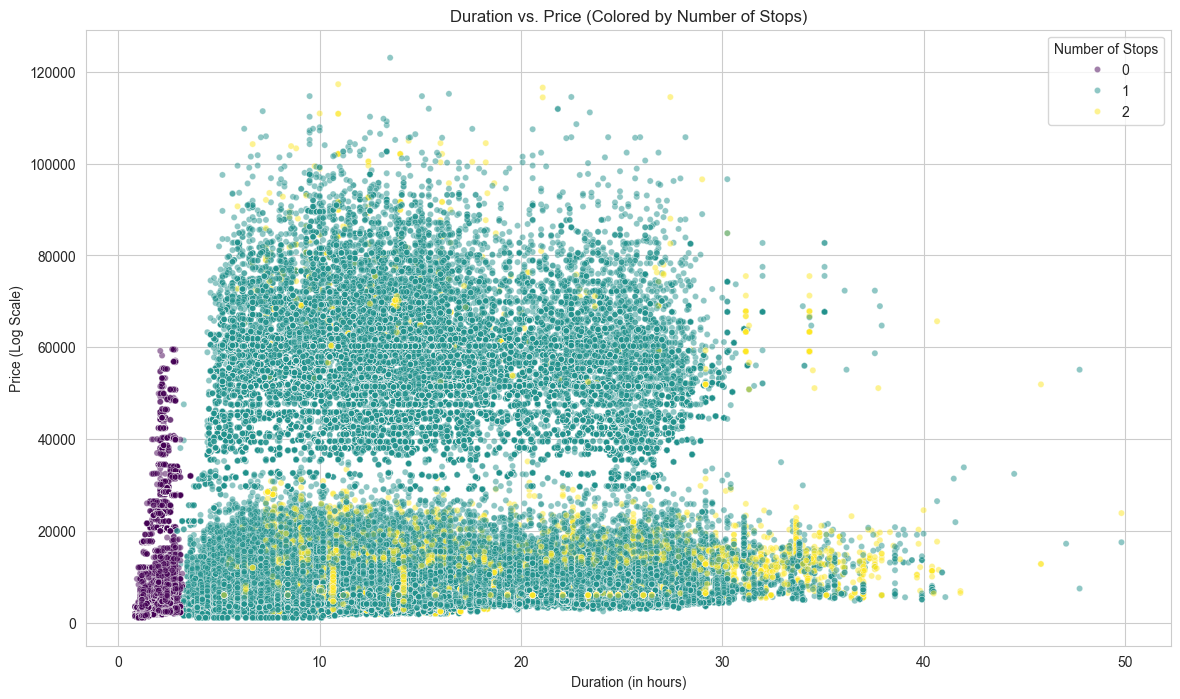

In [11]:
# Plot the price distribution for different numbers of stops
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_processed, x='stops', y='price', palette='coolwarm')
plt.title('Price Distribution by Number of Stops')
plt.xlabel('Number of Stops (0: Non-stop, 1: One stop, 2: Two or more stops)')
plt.ylabel('Price (Log Scale)')
plt.yscale('log') # Use a log scale to better display the price range
plt.show()

# Plot the relationship between duration and price, colored by the number of stops
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_processed, x='duration', y='price', hue='stops', palette='viridis', alpha=0.5, s=20)
plt.title('Duration vs. Price (Colored by Number of Stops)')
plt.xlabel('Duration (in hours)')
plt.ylabel('Price (Log Scale)')
plt.legend(title='Number of Stops')
plt.show()

## Brand Premium: The Pricing Tiers of Airlines
The market positioning of different airlines (e.g., full-service vs. low-cost carriers) directly determines their base fares and pricing strategies. By comparing the price distributions of various airlines, we can clearly see this hierarchy of branding and service.

C:\Users\80999\AppData\Local\Temp\ipykernel_8832\903162067.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_processed, x='airline', y='price', order=airline_order, palette='tab10')


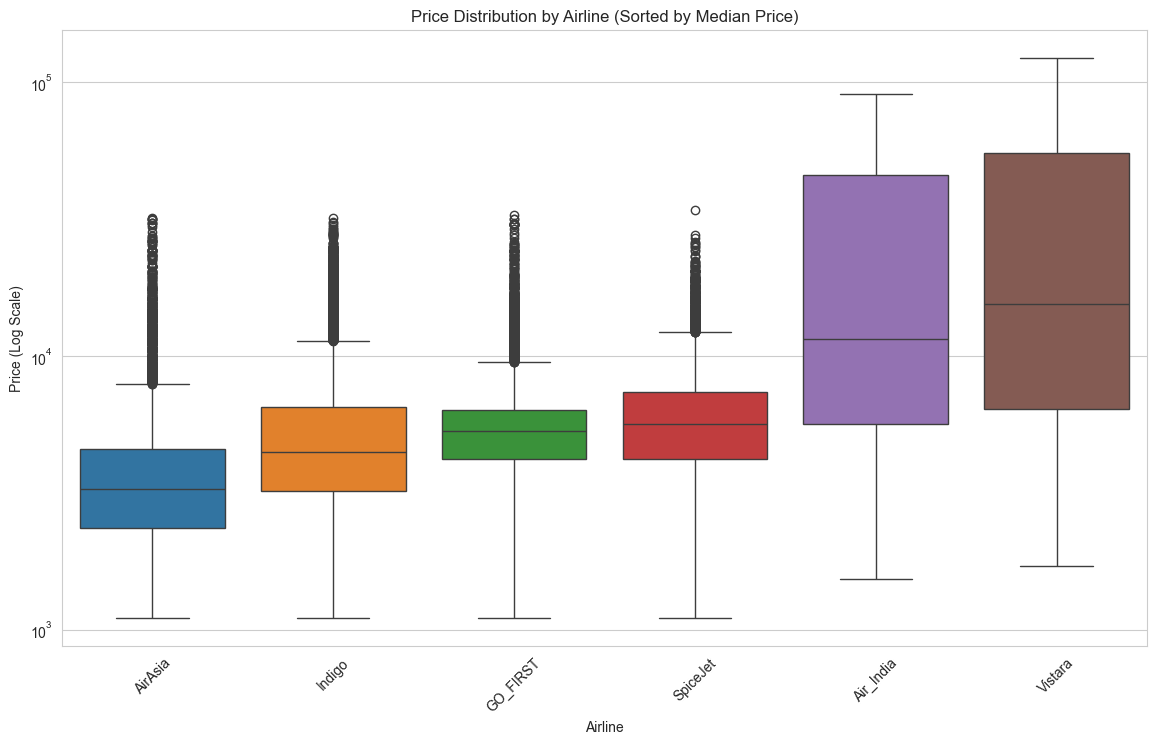

In [12]:
# Calculate the median price for each airline and sort them for ordered plotting
airline_order = df_processed.groupby('airline')['price'].median().sort_values().index

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_processed, x='airline', y='price', order=airline_order, palette='tab10')
plt.title('Price Distribution by Airline (Sorted by Median Price)')
plt.xlabel('Airline')
plt.ylabel('Price (Log Scale)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

## The Geography of Cost: Route-Specific Price Differences
Ticket prices are influenced not only by flight distance but also by geographical factors such as route popularity and market competition. Analyzing the average prices of the most popular routes can reveal the unique price baselines associated with specific routes.

C:\Users\80999\AppData\Local\Temp\ipykernel_8832\3443221030.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_routes, x='route', y='price', order=route_order, palette='cubehelix')


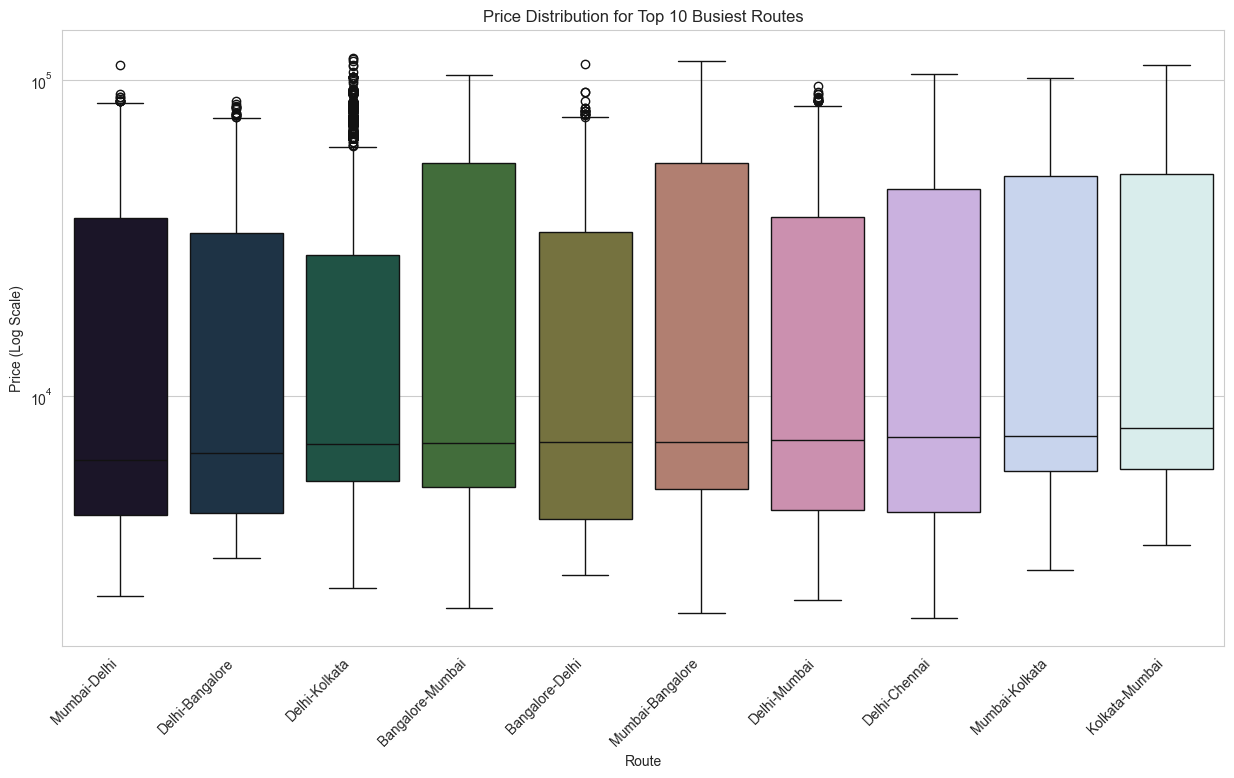

In [13]:
# Find the top 10 most frequent routes in the dataset
top_10_routes = df_processed['route'].value_counts().nlargest(10).index

# Filter the dataframe to include only these top 10 routes
df_top_routes = df_processed[df_processed['route'].isin(top_10_routes)]

# Calculate the median price for each popular route and sort them for ordered plotting
route_order = df_top_routes.groupby('route')['price'].median().sort_values().index

# Plot the price distribution for the top 10 routes
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_top_routes, x='route', y='price', order=route_order, palette='cubehelix')
plt.title('Price Distribution for Top 10 Busiest Routes')
plt.xlabel('Route')
plt.ylabel('Price (Log Scale)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.show()

## The Daily Rhythm: Influence of Departure and Arrival Times
Different times of the day, especially prime times for business travel versus off-peak times for leisure travel, have varying demand elasticities, leading to price differences. We will explore the impact of both departure and arrival times on the average ticket price.

C:\Users\80999\AppData\Local\Temp\ipykernel_8832\3030429742.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_processed, x='departure_time', y='price', order=time_order, palette='plasma', errorbar=None)
C:\Users\80999\AppData\Local\Temp\ipykernel_8832\3030429742.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_processed, x='arrival_time', y='price', order=time_order, palette='plasma', errorbar=None)


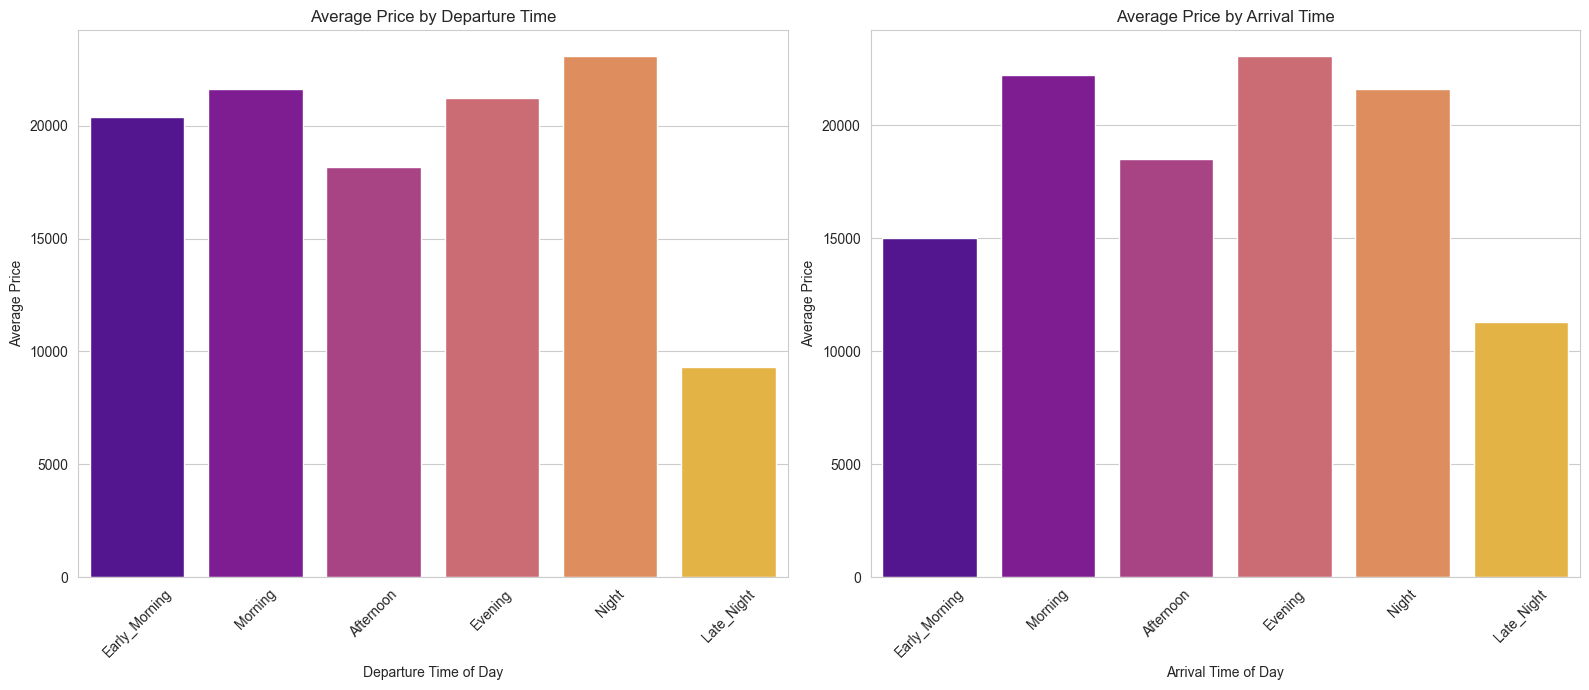

In [14]:
# Define an ordered list for time categories to ensure logical plotting order
time_order = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']

plt.figure(figsize=(16, 7))

# Subplot 1: Impact of departure time on price
plt.subplot(1, 2, 1)
sns.barplot(data=df_processed, x='departure_time', y='price', order=time_order, palette='plasma', errorbar=None)
plt.title('Average Price by Departure Time')
plt.xlabel('Departure Time of Day')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Subplot 2: Impact of arrival time on price
plt.subplot(1, 2, 2)
sns.barplot(data=df_processed, x='arrival_time', y='price', order=time_order, palette='plasma', errorbar=None)
plt.title('Average Price by Arrival Time')
plt.xlabel('Arrival Time of Day')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Flight Price Prediction Framework: A Machine Learning Methodology
This chapter forms the technical core of the report, detailing the process of building, training, and evaluating the machine learning model used to predict flight prices. We will justify our choice of model, validation protocol, and evaluation metrics to provide a rigorous foundation for our findings.

## Framing the Prediction Task
The problem is formally defined as a supervised regression task. The objective is to predict a continuous target variable—the log-transformed price, log(price)—using a given set of flight features (e.g., airline, route, stops, duration, days_left). Using the log-transformed price helps stabilize the model's training process and improves its ability to handle the wide fluctuations in ticket prices.

Before building the model, we must prepare the final set of features. This involves selecting the relevant columns and encoding the remaining nominal categorical features (like airline, route, class, etc.) using One-Hot Encoding. This technique creates new binary columns for each category, preventing the model from assuming any false ordinal relationships between them.

In [15]:
# --- 1. Import modeling libraries (cleaned up redundant imports) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor  # Kept only this lightgbm import
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd # Assuming df_processed is already defined

# Add a robustness check to ensure df_processed exists
if 'df_processed' not in locals() and 'df_processed' not in globals():
    print("Error: 'df_processed' DataFrame is not defined.")
    print("Please ensure 'df_processed' has been created before running this cell.")
else:
    # --- 2. Define Features (X) and Target (y) ---
    # (This logic is the same as your original code and is correct)
    X = df_processed.drop(['price', 'log_price', 'flight', 'source_city',
                           'destination_city', 'Unnamed: 0'], axis=1) 
    y = df_processed['log_price'] 

    X['days_left'] = X['days_left'].astype(float)
    
    # --- 3. Optimization: Explicitly define feature lists ---
    # We avoid using select_dtypes to ensure 'stops' is correctly treated as categorical.
    
    # Define the truly continuous numerical features
    numerical_features = ['duration', 'days_left']

    # Define categorical features.
    # We dynamically get the list by taking all columns in X and excluding the numerical ones.
    categorical_features = [col for col in X.columns if col not in numerical_features]

    print("--- Optimized Feature Definition ---")
    print(f"Explicitly Defined Numerical Features: {numerical_features}")
    print(f"Explicitly Defined Categorical Features: {categorical_features}")

    # Add a check to ensure 'stops' was categorized correctly
    if 'stops' in categorical_features:
        print("\n[Check Passed]: 'stops' has been correctly classified as a Categorical feature.")
    elif 'stops' in numerical_features:
        print("\n[Check Failed]: 'stops' is still classified as Numerical. Please check the numerical_features list!")

    # --- 4. Display the final features being used for the model ---
    print("\nFeatures (X) head: ") 
    print(X.head())

--- Optimized Feature Definition ---
Explicitly Defined Numerical Features: ['duration', 'days_left']
Explicitly Defined Categorical Features: ['airline', 'departure_time', 'stops', 'arrival_time', 'class', 'route']

[Check Passed]: 'stops' has been correctly classified as a Categorical feature.

Features (X) head: 
    airline departure_time  stops   arrival_time    class  duration  \
0  SpiceJet        Evening      0          Night  Economy      2.17   
1  SpiceJet  Early_Morning      0        Morning  Economy      2.33   
2   AirAsia  Early_Morning      0  Early_Morning  Economy      2.17   
3   Vistara        Morning      0      Afternoon  Economy      2.25   
4   Vistara        Morning      0        Morning  Economy      2.33   

   days_left         route  
0        1.0  Delhi-Mumbai  
1        1.0  Delhi-Mumbai  
2        1.0  Delhi-Mumbai  
3        1.0  Delhi-Mumbai  
4        1.0  Delhi-Mumbai  


## Model Selection Strategy: A Comparative Approach
Instead of relying on a single algorithm, we adopted a rigorous comparative strategy to identify the optimal predictor for flight prices. We selected five distinct models spanning different levels of complexity and learning mechanisms:

1. Linear Regression: Serves as the baseline to test for linear relationships.

2. Decision Tree Regressor: A fundamental non-linear model used to establish a baseline for tree-based methods.

3. Random Forest Regressor: A Bagging (Bootstrap Aggregating) ensemble method that trains multiple decision trees in parallel. It is chosen for its ability to reduce variance and resist overfitting.

4. Gradient Boosting Machines (XGBoost & LightGBM): Two state-of-the-art Boosting frameworks that build trees sequentially to correct previous errors. They are included to test if reducing bias yields better results than reducing variance.

By benchmarking these diverse algorithms, we ensure that our final choice is empirically justified by performance metrics ($R^2$ and MAE) rather than assumption.

## Model Training and Validation Protocol
To ensure an objective and reliable evaluation of our model, we follow a standard machine learning workflow.

1. Data Splitting: The preprocessed dataset is randomly divided into a training set (80%) and a testing set (20%). The model learns exclusively from the training data. Its final performance is then evaluated on the unseen test data. This approach provides an unbiased estimate of the model's ability to generalize to new, real-world data and helps prevent overfitting.

2. Training Process: The LightGBM model is trained on the training set. The goal is to minimize the error between its predictions and the actual $log(price)$ values. It does this by iteratively building a series of decision trees, where each new tree corrects the errors of the previous ones.

In [16]:
# [40]: # Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape} samples")
print(f"Testing set size: {X_test.shape} samples")

from sklearn import set_config
set_config(enable_metadata_routing=True)

# Create a preprocessing pipeline for categorical features
# We use OneHotEncoder, which is suitable for nominal features.
# handle_unknown='ignore' ensures that if a category appears in the test set
# but not the train set, it doesn't cause an error.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns as they are
)
preprocessor.set_output(transform="pandas")
preprocessor.verbose_feature_names_out = False


Training set size: (240122, 8) samples
Testing set size: (60031, 8) samples


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Define a dictionary that contains the five models
models_dict = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
}

# 3. Initialize the results list
results = []

# 4. Loop over training and evaluation
print("Starting Model Comparison Loop...")

for name, model in models_dict.items():
    print(f"\nProcessing: {name}...")
    
    # Build the pipeline: preprocessing + model
    current_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train model
    current_pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred_log = current_pipeline.predict(X_test)
    
    # Reconstruct the predicted and actual values ​​(expm1)
    y_pred_orig = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test)
    
    # Calculation indicators
    r2 = r2_score(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    
    print(f"  -> R2: {r2:.4f}, MAE: {mae:.2f}")
    
    # Store output
    results.append({
        "Model": name,
        "R2 Score": r2,
        "MAE": mae,
        "Pipeline_Object": current_pipeline # Store the trained model for later use.
    })

print("\nModel Comparison Complete.")

Starting Model Comparison Loop...

Processing: Linear Regression...
  -> R2: 0.8837, MAE: 4550.68

Processing: Decision Tree...
  -> R2: 0.9766, MAE: 1159.25

Processing: Random Forest...
  -> R2: 0.9850, MAE: 1067.45

Processing: XGBoost...
  -> R2: 0.9653, MAE: 2342.85

Processing: LightGBM...
  -> R2: 0.9619, MAE: 2473.75

Model Comparison Complete.


## Performance Evaluation: Quantifying Prediction Accuracy
After training, the model's performance is assessed on the held-out test set using two key regression metrics:
1. R-squared ($R^2$): This metric measures the proportion of the variance in the target variable (price) that is predictable from the features. It ranges from 0 to 1, with values closer to 1 indicating a better model fit. An $R^2$ of 0.98, for example, means the model explains 98% of the price volatility.

2. Mean Absolute Error (MAE): This metric calculates the average of the absolute differences between the predicted and actual prices. Since we predicted $log(price)$, we must convert the predictions and true values back to their original price scale before calculating the MAE. This gives us an error value in the original currency unit, making it highly interpretable. An MAE of 1800 means the model's predictions are, on average, off by 1800 currency units.

To demonstrate the effectiveness of our chosen model, we compare its performance against a simpler baseline model: Linear Regression.


--- Final Model Comparison ---
            Model  R2 Score         MAE
    Random Forest  0.984992 1067.446892
    Decision Tree  0.976581 1159.253162
          XGBoost  0.965334 2342.850150
         LightGBM  0.961857 2473.746264
Linear Regression  0.883697 4550.678159


C:\Users\80999\AppData\Local\Temp\ipykernel_8832\1113890748.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_df, x="Model", y="R2 Score", palette="viridis")
C:\Users\80999\AppData\Local\Temp\ipykernel_8832\1113890748.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_df, x="Model", y="MAE", palette="magma")


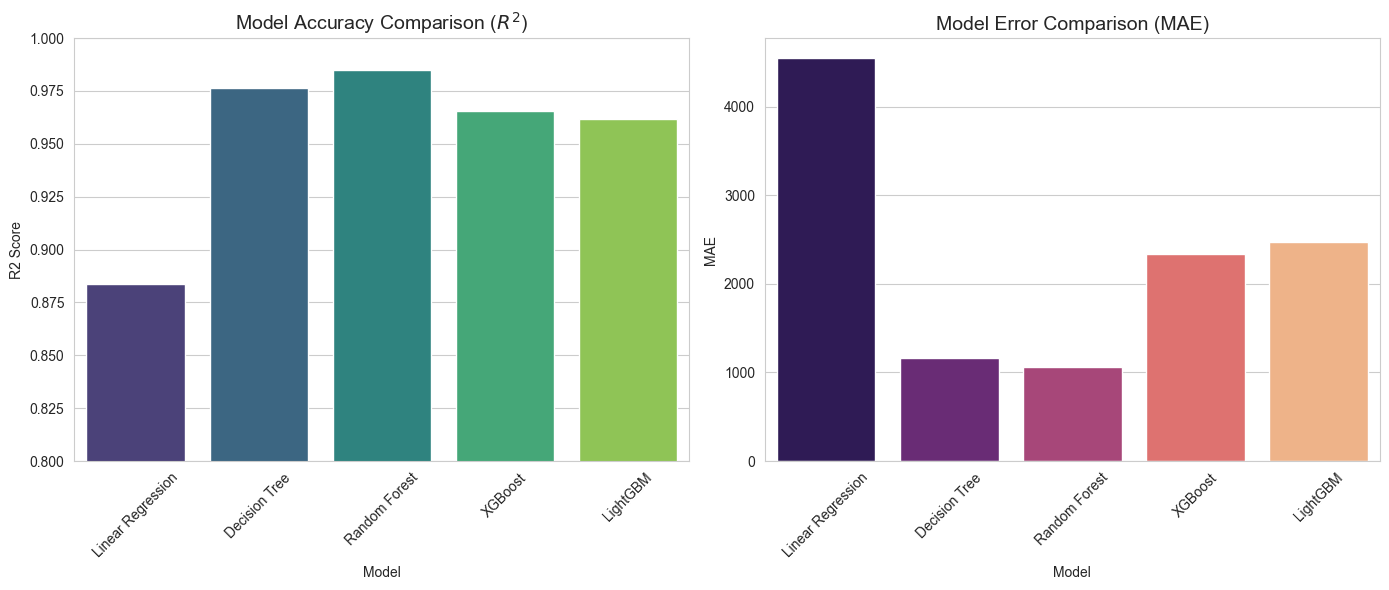

In [18]:
# 1. Create the result DataFrame
performance_df = pd.DataFrame(results).drop(columns=['Pipeline_Object']) # Do not show the pipeline object in the table
print("\n--- Final Model Comparison ---")
print(performance_df.sort_values(by="R2 Score", ascending=False).to_string(index=False))

# 2. Visualize the comparison (Bar Chart)
plt.figure(figsize=(14, 6))

# Subplot 1: R2 Score comparison
plt.subplot(1, 2, 1)
sns.barplot(data=performance_df, x="Model", y="R2 Score", palette="viridis")
plt.title("Model Accuracy Comparison ($R^2$)", fontsize=14)
plt.ylim(0.8, 1.0) # Set y-axis range to make the differences clearer
plt.xticks(rotation=45)

# Subplot 2: MAE comparison
plt.subplot(1, 2, 2)
sns.barplot(data=performance_df, x="Model", y="MAE", palette="magma")
plt.title("Model Error Comparison (MAE)", fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Deciphering the Optimal Booking Window: Model Interpretation and Insights

With high-performance models trained and validated, this chapter uses advanced model interpretation techniques to directly answer the core question: when is the best time to book a flight? We will delve into the internal logic of our **best-performing model** to understand how it makes predictions, with a special focus on the role of `days_left`.

### Identifying the Most Influential Price Drivers

By extracting feature importance scores from our trained **Random Forest model (the top performer in our comparison)**, we can quantify the overall contribution of each feature to the model's predictions. These scores reflect how effectively each feature is used to split the data across the ensemble of decision trees, thereby reducing prediction error.

It is crucial to note that while class dictates the baseline price tier (Economy vs. Business), days_left acts as the primary temporal driver, determining the variance within those tiers. This distinction is vital for actionable traveler recommendations.

This analysis helps us understand the hierarchy of factors that determine flight prices. It answers the question: Is *when* you book more important than *what* you book?

The best performing model is Random Forest, using it for interpretation.


C:\Users\80999\AppData\Local\Temp\ipykernel_8832\3230856900.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


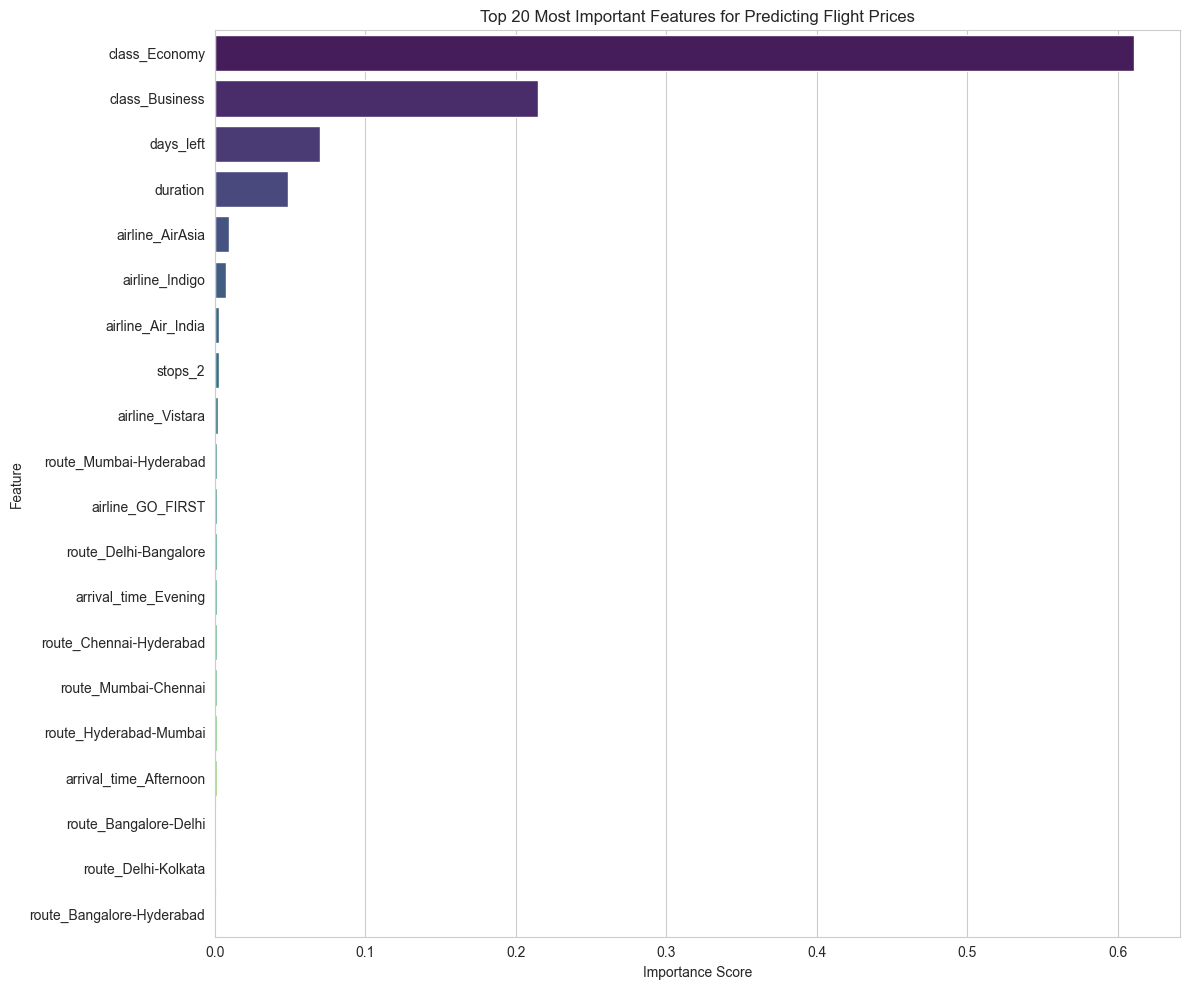

Top 10 Most Important Features:
               feature  importance
         class_Economy    0.610898
        class_Business    0.214605
             days_left    0.069506
              duration    0.048393
       airline_AirAsia    0.009435
        airline_Indigo    0.007137
     airline_Air_India    0.002627
               stops_2    0.002482
       airline_Vistara    0.002214
route_Mumbai-Hyderabad    0.001361


In [19]:
# --- Feature Importance Analysis ---
# Automatically get the best-performing model
best_result = max(results, key=lambda x: x['R2 Score'])
best_pipeline = best_result['Pipeline_Object']
best_model_name = best_result['Model']

print(f"The best performing model is {best_model_name}, using it for interpretation.")

model = best_pipeline.named_steps['model']
preprocessor = best_pipeline.named_steps['preprocessor']


# Get feature names after one-hot encoding from the preprocessor
# This gives us the names of all columns in the order the model sees them
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Clean up feature names for better readability
# e.g., 'cat__airline_Vistara' becomes 'airline_Vistara'
# e.g., 'remainder__duration' becomes 'duration'
feature_importance_df['feature'] = feature_importance_df['feature'].str.replace('cat__', '').str.replace('remainder__', '')

# Sort features by importance and select the top 20
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plot the top 20 most important features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 20 Most Important Features for Predicting Flight Prices')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Display the top features as a table
print("Top 10 Most Important Features:")
print(top_features.head(10).to_string(index=False))

Using the best-performing model for PDP analysis: Random Forest
Using a sample of 2000 records for PDP calculation.
Calculating Partial Dependence... (This may take a moment)


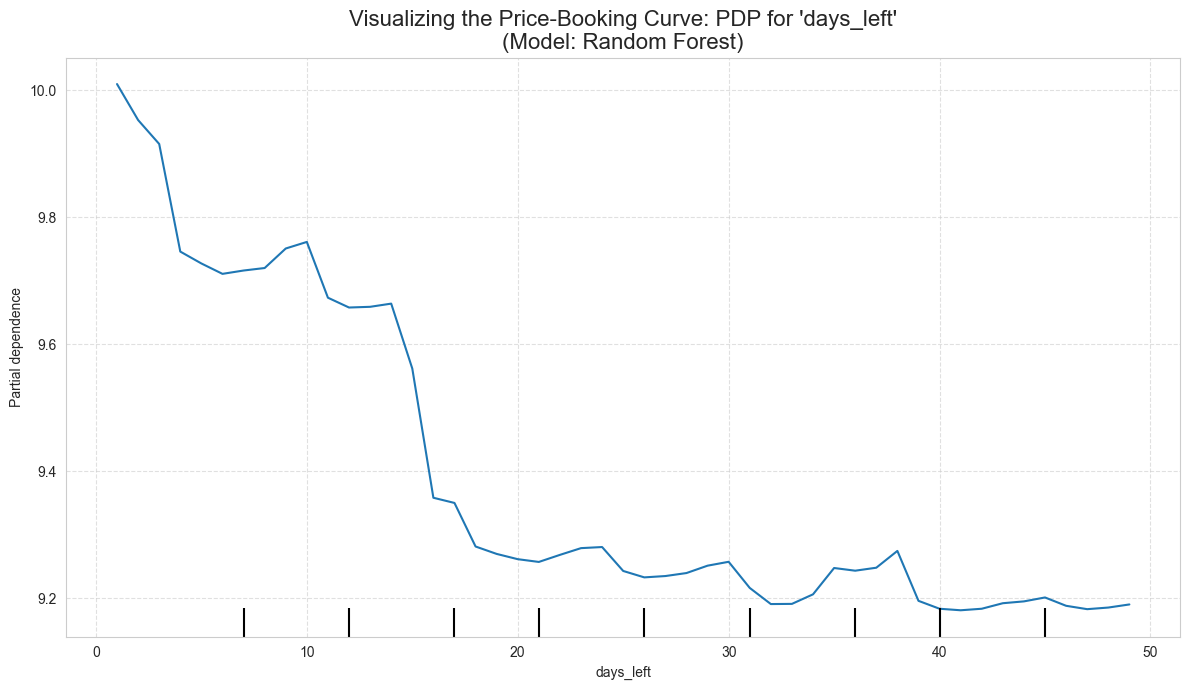

In [ ]:
# --- 1.Automatically get the best-performing model ---
# Find the model with the highest R2 score from the previous results list
best_result = max(results, key=lambda x: x['R2 Score'])
best_pipeline = best_result['Pipeline_Object'] # Retrieve the trained pipeline
best_model_name = best_result['Model']

print(f"Using the best-performing model for PDP analysis: {best_model_name}")

# --- 2. Prepare the data for the PDP plot  ---
# To speed up computation, if the dataset is large, only take 2,000 samples
if len(X_train) > 2000:
    X_train_sample = X_train.sample(n=2000, random_state=42)
    print(f"Using a sample of {len(X_train_sample)} records for PDP calculation.")
else:
    X_train_sample = X_train
    print(f"Using full training set of {len(X_train_sample)} records for PDP calculation.")

# --- 3. Generate the Partial Dependence Plot  ---
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 7))
print("Calculating Partial Dependence... (This may take a moment)")
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=best_pipeline,       
    X=X_train_sample,              
    features=['days_left'],        
    ax=ax,
    grid_resolution=50
)

# --- 4. Beautify the plot ---
ax.set_title(f"Visualizing the Price-Booking Curve: PDP for 'days_left'\n(Model: {best_model_name})", fontsize=16)
ax.set_xlabel("Days Left Before Departure (days_left)", fontsize=12)
ax.set_ylabel("Partial Dependence (on predicted log_price)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Save and display
plt.tight_layout()
plt.savefig(OUTPUT_DIR/ 'pdp_days_left_vs_price.png')
plt.show()

## Precise Calculation of Optimal Booking Window
### Step 1: Preparation and Data Aggregation
First, we need to aggregate the data by "remaining days", to eliminate noise from individual flights and thus perform a mathematical fit.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 1. Prepare Aggregated Data: Calculate daily average price
# This removes noise from individual flights to smooth the regression curve
days_price = df_processed.groupby('days_left')['price'].mean().reset_index().sort_values('days_left')
X_agg = days_price['days_left'].values.reshape(-1, 1)
y_agg = days_price['price'].values

print("Data aggregation complete. Preparing for mathematical regression analysis...")

Data aggregation complete. Preparing for mathematical regression analysis...


### Step 2: Polynomial Regression (Calculate the Absolute Lowest Price Day) 
Fit the price curve using a quadratic function and calculate the vertex of the parabola (i.e., the day with the lowest price).

In [22]:
# --- Method A: Polynomial Regression ---
# Used to find the 'absolute minimum point' of the price curve

# 1. Fit a quadratic polynomial (Degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_agg)

linreg = LinearRegression()
linreg.fit(X_poly, y_agg)

# 2. Extract coefficients y = b0 + b1*x + b2*x^2
b1, b2 = linreg.coef_
intercept = linreg.intercept_

# 3. Calculate the vertex (Parabola vertex formula: x = -b1 / 2b2)
optimal_day = -b1 / (2 * b2)

# 4. Generate the fitted curve for plotting
X_range = np.linspace(X_agg.min(), X_agg.max(), 100).reshape(-1, 1)
y_poly_pred = linreg.predict(poly.transform(X_range))

print(f"--- Polynomial Regression Results ---")
if b2 > 0: # Ensure the curve is convex (opens upwards)
    print(f"Convex curve detected.")
    print(f"Calculated theoretical optimal booking lead time (Lowest Price Point): {optimal_day:.1f} days")
else:
    print("Curve is not convex; unable to calculate a single optimal point using this method.")

--- Polynomial Regression Results ---
Convex curve detected.
Calculated theoretical optimal booking lead time (Lowest Price Point): 37.0 days


### Step 3: Piecewise Linear Regression (Finding Price Breakpoints) 
This step is used to find the "breakpoint," which is the day when prices change from stable to a sharp increase.

In [23]:
# --- Method B: Piecewise Linear Regression ---
# Used to find the 'breakpoint' where prices start to rise sharply

best_sse = np.inf
best_breakpoint = None
best_models = (None, None)

# Search for potential breakpoints (excluding extreme ends to avoid edge cases)
search_range = range(5, 45) 

for day in search_range:
    # Split data into two segments: <= day and > day
    mask_left = (X_agg <= day).flatten()
    mask_right = (X_agg > day).flatten()
    
    # Skip if segments are too small
    if np.sum(mask_left) < 2 or np.sum(mask_right) < 2: continue
        
    # Fit two separate lines
    model_left = LinearRegression().fit(X_agg[mask_left], y_agg[mask_left])
    model_right = LinearRegression().fit(X_agg[mask_right], y_agg[mask_right])
    
    # Calculate Sum of Squared Errors (SSE)
    pred_left = model_left.predict(X_agg[mask_left])
    pred_right = model_right.predict(X_agg[mask_right])
    sse = np.sum((y_agg[mask_left] - pred_left)**2) + np.sum((y_agg[mask_right] - pred_right)**2)
    
    # Record the best breakpoint
    if sse < best_sse:
        best_sse = sse
        best_breakpoint = day
        best_models = (model_left, model_right)

print(f"\n--- Piecewise Regression Results ---")
print(f"Detected Price Hike Breakpoint: {best_breakpoint} days prior")
print(f"Recommendation: Book before {best_breakpoint} days prior to avoid sharp price increases.")


--- Piecewise Regression Results ---
Detected Price Hike Breakpoint: 15 days prior
Recommendation: Book before 15 days prior to avoid sharp price increases.


### Step 4: Comprehensive Visualization 
Plot the feature importance of the random forest, the minimum point of the multinomial regression, and the inflection point of the piecewise regression on a single graph.

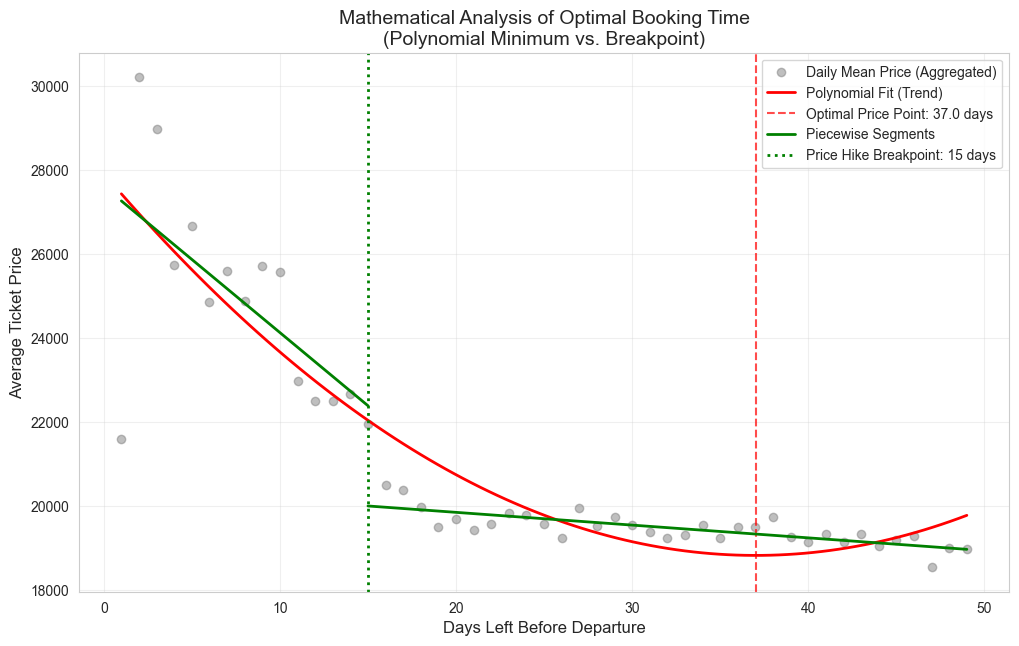

In [24]:
# --- Comprehensive Visualization ---
plt.figure(figsize=(12, 7))

# 1. Plot original daily mean scatter points
plt.scatter(X_agg, y_agg, color='gray', alpha=0.5, label='Daily Mean Price (Aggregated)')

# 2. Plot Polynomial Fit Curve (Red)
plt.plot(X_range, y_poly_pred, color='red', linewidth=2, label='Polynomial Fit (Trend)')
# Mark the lowest point
if b2 > 0:
    plt.axvline(optimal_day, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal Price Point: {optimal_day:.1f} days')

# 3. Plot Piecewise Regression Lines (Green)
if best_breakpoint:
    # Left segment
    x_l = np.linspace(X_agg.min(), best_breakpoint, 50).reshape(-1, 1)
    y_l = best_models[0].predict(x_l)
    plt.plot(x_l, y_l, color='green', linewidth=2, linestyle='-', label='Piecewise Segments')
    
    # Right segment
    x_r = np.linspace(best_breakpoint, X_agg.max(), 50).reshape(-1, 1)
    y_r = best_models[1].predict(x_r)
    plt.plot(x_r, y_r, color='green', linewidth=2, linestyle='-')
    
    # Mark the breakpoint
    plt.axvline(best_breakpoint, color='green', linestyle=':', linewidth=2,
                label=f'Price Hike Breakpoint: {best_breakpoint} days')

plt.title('Mathematical Analysis of Optimal Booking Time\n(Polynomial Minimum vs. Breakpoint)', fontsize=14)
plt.xlabel('Days Left Before Departure', fontsize=12)
plt.ylabel('Average Ticket Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Final Conclusion and Analysis Summary

This project successfully navigated an end-to-end data science workflow to analyze the determinants of flight prices and precisely answer the core question: **When is the best time to book a flight?**

**The central conclusion is: A powerful and critical non-linear relationship exists between flight price and the booking lead time (`days_left`).** The analysis consistently demonstrates that **booking within 20 days of departure results in a sharp price increase.** Conversely, the **optimal booking window**—offering the lowest and most stable pricing—is found when booking between **20 and 50 days in advance**.

This conclusion is robustly supported by three progressive, corroborating analytical perspectives:

1.  **Exploratory Data Analysis (EDA):** The initial "Average Price vs. Days Left" visualization (Page 7) first uncovered this non-linear "price-time curve". This chart revealed a clear inflection point where average prices begin to climb dramatically at approximately the 20-day mark, forming a key hypothesis for the modeling phase.

2.  **Model Building and Evaluation:** This phase confirmed the necessity of modeling this non-linearity. By benchmarking five distinct algorithms, the **Random Forest Regressor** emerged as the superior model, achieving an exceptional **$R^2$ of 0.985**. It significantly outperformed the baseline Linear Regression ($R^2$: 0.883) and slightly edged out boosting methods like XGBoost and LightGBM. This performance gap validates that the relationship between price and time is complex and far from linear.

3.  **Model Interpretation:** Two techniques were used to quantify and confirm the finding:
    * **Feature Importance** analysis identified `days_left` as a **top-tier influential feature** (ranking 3rd overall), confirming its critical role alongside service class.
    * **The Partial Dependence Plot (PDP)** provided the most intuitive evidence. By isolating the marginal effect of `days_left` using the best-performing Random Forest model, the PDP's resulting curve perfectly matched the "inflection point" discovered during EDA, providing definitive, model-based confirmation of the "20-day" price sensitivity threshold.

### Comprehensive Insights

While `days_left` is a critical temporal driver, the Random Forest model also highlighted other key factors in flight pricing hierarchy:

* **Service Class Dominance:** `class_Economy` and `class_Business` were identified as the **top two most important features** (with importance scores of ~0.61 and ~0.21 respectively). This indicates that the cabin class is the absolute strongest predictor of price, outweighing even the booking time.
* **Flight Convenience:** `duration` (flight time) remained a significant factor (ranking 4th), proving that travelers pay a premium for shorter, more direct flights, though this factor is secondary to service class and booking timing.

**In summary**, this report clearly deconstructs the complex mechanisms of flight pricing—from initial exploration and intelligent feature engineering, through robust multi-model benchmarking, to advanced interpretation. It delivers a data-driven, actionable recommendation: **To secure the best price, travelers should aim to book within the 20 to 50-day window before departure.**